## LOAD DS

In [1]:
# TODO:
# - histogram of bbox size per category
# - histogram of number of objects per image ---> make sure images with 0 objects are included
# - analyze per camera index!! (especially for bbox heatmaps)

In [2]:
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import os

import seaborn as sns

instance_threshold = 1000
using_path_for_camera_index = True
# useful reference: https://github.com/imagry/AVM_PSD/blob/main/src/data/psd_data.ipynb

In [3]:
coco_path = "/home/imagry/offline_data/sheba_trips/entron_28-08/entron_28-08_LOCAL_OVERSAMPLED_train.json"

with open(coco_path, "r") as f:
    data = json.load(f)
print(data.keys())

ds_name  = os.path.basename(coco_path).split('.')[0]

cognata = False

dict_keys(['images', 'annotations', 'categories', 'cameras_info'])


In [4]:
class_mapping = {x['id']:x['name'] for x in data['categories']}

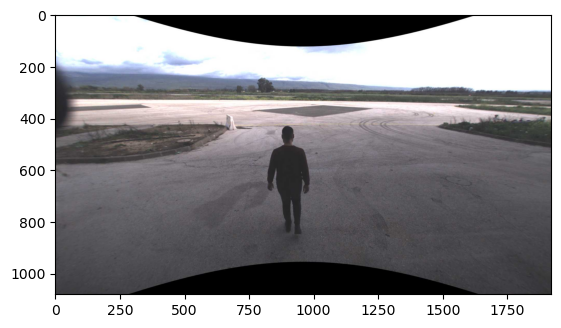

In [5]:
first_image = cv2.imread(data['images'][0]['file_name'])
plt.imshow(first_image[:,:,::-1])

# IMAGES df

## cam_config

In [6]:
if 'camera_type' not in data['images'][-1].keys():
    for index,image_info in enumerate(data['images']):
        image_info.update(
            {
                "camera_type": 'zed',
                "fov": 90
            }
        )

In [7]:
image_df = pd.DataFrame(data['images'])
image2type = dict(zip(image_df['id'], image_df['camera_type']))

image_df['cam_config'] = (image_df['camera_type']) + '_' + ((image_df['fov'].values.astype(str)))
image2config = dict(zip(image_df['id'], image_df["cam_config"]))

image_df['camera_index'] = image_df['file_name'].apply(lambda x: int(x.split('/')[-3]))

image_df.head(5)

,file_name,id,fov,camera_type,cam_config,camera_index
0,/home/imagry/offline_data/sheba_trips/images/2...,0,110,entron,entron_110,2
1,/home/imagry/offline_data/sheba_trips/images/2...,1,110,entron,entron_110,2
2,/home/imagry/offline_data/sheba_trips/images/2...,2,110,entron,entron_110,2
3,/home/imagry/offline_data/sheba_trips/images/2...,3,110,entron,entron_110,2
4,/home/imagry/offline_data/sheba_trips/images/2...,4,110,entron,entron_110,2


In [8]:
image_df['basename'] = image_df['file_name'].apply(lambda x: os.path.basename(x))
# interval__image_df = image_df.groupby('camera_index')
# for i,d in interval__image_df:
#     d = d.sort_values(by='basename')
# interval__image_df.get_group('4').head()
# image_df.sort_values(['camera_index', 'basename'])

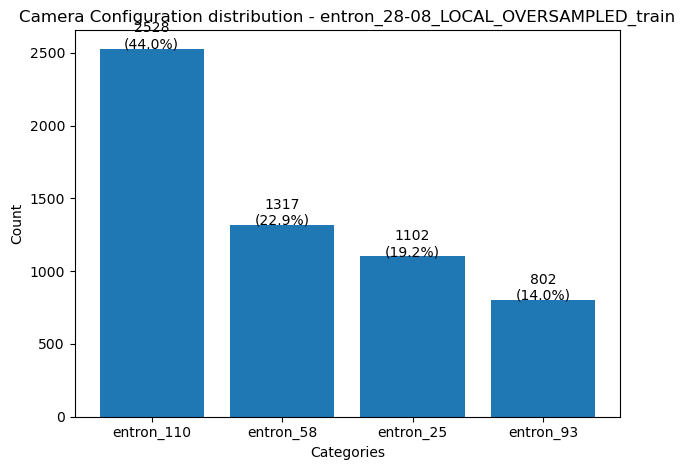

In [9]:
# Calculate value counts and normalize
cam_config_value_counts = image_df['cam_config'].value_counts()
cam_config_normalized_value_counts = image_df['cam_config'].value_counts(normalize=True)

# Create the bar plot
plt.bar(cam_config_value_counts.index, cam_config_value_counts.values)

# Add text annotations for absolute counts and percentages above each bar
for i, count in enumerate(cam_config_value_counts):
    percent = cam_config_normalized_value_counts[i] * 100
    plt.text(i, count + 1, f'{count}\n({percent:.1f}%)', ha='center')

# Set the x-axis label
plt.xlabel('Categories')

# Set the y-axis label
plt.ylabel('Count')

# Set the title
plt.title(f'Camera Configuration distribution - {ds_name}')

# Show the plot
plt.tight_layout()
plt.show()

## camera index

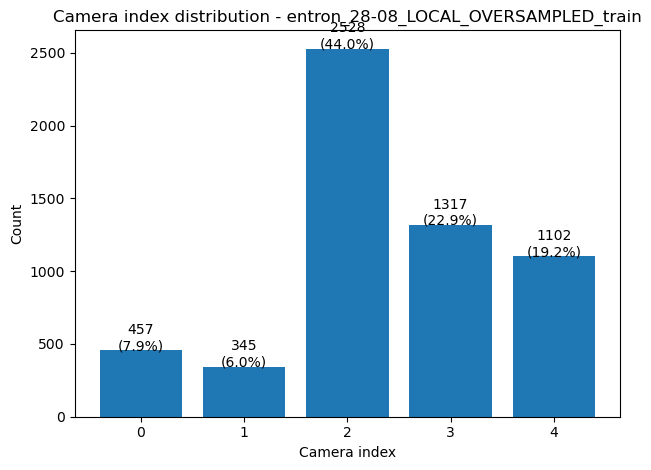

In [29]:
if using_path_for_camera_index:
    image_df['camera_index'] = image_df['file_name'].apply(lambda x: x.split('/')[-3])

cam_index_value_counts = image_df['camera_index'].value_counts().sort_index(ascending=True)
cam_index_normalized_value_counts = image_df['camera_index'].value_counts(normalize=True).sort_index(ascending=True)

# Create the bar plot
plt.bar(cam_index_value_counts.index, cam_index_value_counts.values)

# Add text annotations for absolute counts and percentages above each bar
for i, count in enumerate(cam_index_value_counts):
    percent = cam_index_normalized_value_counts[i] * 100
    plt.text(i, count + 1, f'{count}\n({percent:.1f}%)', ha='center')

# Set the x-axis label
plt.xlabel('Camera index')

# Set the y-axis label
plt.ylabel('Count')

# Set the title
plt.title(f'Camera index distribution - {ds_name}')

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
if cognata:
    image_shape = cv2.imread('/home/imagry/offline_data/cognata/old_before_080523/645a086a4dac90003059f850/FrontCam01_jpg/0000000033.jpg').shape
else:
    image_shape = cv2.imread(image_df.iloc[0]['file_name']).shape
print(image_shape)

(1080, 1920, 3)


# ANNOTATIONS df

## conversions

In [12]:
ann_df = pd.DataFrame(data['annotations'])
ann_df['image_fov_deg'] = ann_df['image_fov'].apply(np.rad2deg)
ann_df['azimuth_3d_deg'] = ann_df['azimuth_3d'].apply(np.rad2deg)
ann_df['azimuth_2d_deg'] = ann_df['azimuth_2d'].apply(np.rad2deg)
ann_df['cam_config'] = ann_df['image_id'].apply(lambda i: image2config[i])
print(f'{len(ann_df) = }')
ann_df.head(3)

len(ann_df) = 199383


,image_id,id,category_id,bbox,rotation_y,depth,alpha,location,azimuth_3d,azimuth_2d,...,cx_3d,cy_3d,dim,pitch_angle,roll_angle,min_depth,image_fov_deg,azimuth_3d_deg,azimuth_2d_deg,cam_config
0,0,1,1,"[822, 432, 164, 419]",-1.561520,2.77,-1.485853,"[-0.21, 0.41, 2.77]",-0.075668,-0.083117,...,909.039047,646.775330,"[1.7, 0.62, 0.6]",-0.345924,-0.0,2.485078,110.0,-4.335430,-4.762236,entron_110
1,0,2,16,"[660, 387, 45, 62]",-2.173995,13.47,-1.763651,"[-5.86, 3.085, 13.47]",-0.410344,-0.391512,...,667.565885,412.247213,"[1.05, 0.55, 1.7]",-0.317650,-0.0,12.656826,110.0,-23.511007,-22.432012,entron_110
2,1,3,1,"[819, 425, 164, 418]",-1.561520,2.85,-1.484480,"[-0.22, 0.46499999999999997, 2.85]",-0.077040,-0.087547,...,908.110936,636.702346,"[1.75, 0.63, 0.6]",-0.345924,-0.0,2.565034,110.0,-4.414079,-5.016087,entron_110


## number of objects per image

max(df_lengths) = 145
min(df_lengths) = 1


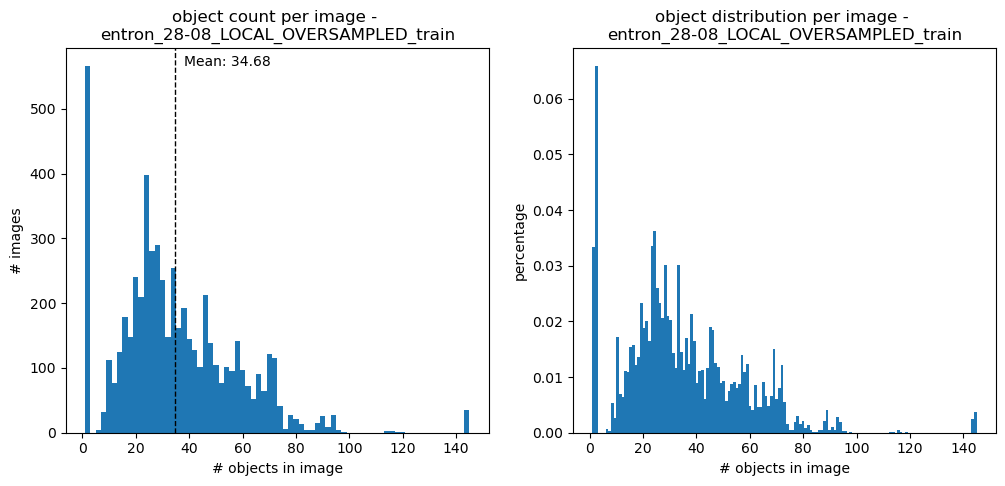

In [13]:
objects_per_image_df = ann_df.groupby('image_id', dropna=False)


df_lengths = [len(object_per_image_df) for group,object_per_image_df in objects_per_image_df]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
min_ylim, max_ylim = plt.ylim()

y,x,_ = axes[0].hist(df_lengths, bins=int(max(df_lengths)/2))
axes[0].set_title(f'object count per image - \n{ds_name}')
axes[0].axvline(np.mean(df_lengths), color='k', linestyle='dashed', linewidth=1)
axes[0].text(np.mean(df_lengths)*1.1, y.max(), 
             'Mean: {:.2f}'.format(np.mean(df_lengths)))
axes[0].set_xlabel('# objects in image')
axes[0].set_ylabel('# images')

axes[1].hist(df_lengths, density=True, bins=max(df_lengths))
axes[1].set_title(f'object distribution per image - \n{ds_name}')
axes[1].set_xlabel('# objects in image')
axes[1].set_ylabel('percentage')

print(f'{max(df_lengths) = }')
print(f'{min(df_lengths) = }')

In [14]:
ann_df = pd.DataFrame(data['annotations'])
images_with_one_ann = []
for image_id, (image, ann_df_by_image) in enumerate(ann_df.groupby("image_id")):
    if len(ann_df_by_image) == 1:
        # print(image)
        images_with_one_ann.append(image)

images_with_one_ann = [image_df.iloc[index]['file_name'] for index in images_with_one_ann]
len(images_with_one_ann)

190

In [15]:
# list images with one annotation

mask = [True if length == 1 else False for length in df_lengths]
images_with_one_ann = image_df.loc[mask]
print(images_with_one_ann['file_name'])

376     /home/imagry/offline_data/sheba_trips/images/2...
377     /home/imagry/offline_data/sheba_trips/images/2...
378     /home/imagry/offline_data/sheba_trips/images/2...
379     /home/imagry/offline_data/sheba_trips/images/2...
380     /home/imagry/offline_data/sheba_trips/images/2...
                              ...                        
561     /home/imagry/offline_data/sheba_trips/images/2...
562     /home/imagry/offline_data/sheba_trips/images/2...
563     /home/imagry/offline_data/sheba_trips/images/2...
564     /home/imagry/offline_data/sheba_trips/images/2...
4340    /home/imagry/offline_data/sheba_trips/images/2...
Name: file_name, Length: 190, dtype: object


## categories

In [16]:
# COUNT VALUES
ann_df.value_counts('category_id', normalize=True, sort=count)


category_id
3      0.228354
16     0.214030
194    0.212591
193    0.104718
85     0.062357
1      0.046749
14     0.020137
97     0.014545
17     0.013732
8      0.010502
137    0.007889
6      0.007418
4      0.005828
55     0.005627
138    0.004027
58     0.003711
11     0.003400
24     0.003165
53     0.003014
54     0.002563
166    0.002523
2      0.002247
99     0.002152
12     0.001876
178    0.001700
146    0.001615
41     0.001259
57     0.001209
176    0.001159
186    0.001108
177    0.000918
18     0.000828
29     0.000742
181    0.000732
98     0.000682
184    0.000627
174    0.000622
9      0.000567
190    0.000552
189    0.000507
180    0.000431
188    0.000426
183    0.000291
179    0.000241
185    0.000241
187    0.000206
75     0.000171
84     0.000005
141    0.000005
dtype: float64

In [17]:
category_counter = defaultdict(int)
category_exists_counter = defaultdict(int)
num_images = 0

for image_id, image_ann in tqdm(ann_df.groupby("image_id")):
    num_images += 1
    
    for cat, cnt in image_ann['category_id'].value_counts().items():
        category_counter[cat] += cnt
        category_exists_counter[cat] += 1

# category_counter, category_exists_counter

100%|██████████| 5749/5749 [00:00<00:00, 8442.56it/s]


In [18]:

# class_names = [class_mapping.get(index) for index in category_counter.keys()]
# class_names = [item.replace(' ', '\n') for item in class_names]

# plt.title("#intances of each object category")
# # plt.bar(category_counter.keys(), category_counter.values())
# plt.bar(class_names, category_counter.values())
# plt.xticks(rotation=45)
# plt.tight_layout() 
# plt.show()

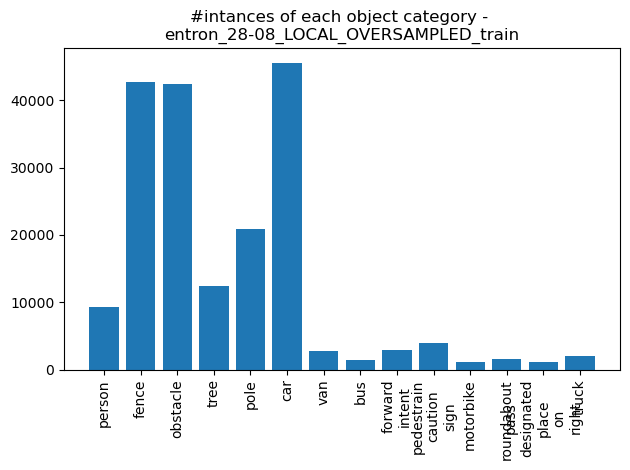

In [19]:
filtered_category_counter = {key:value for key,value in category_counter.items() if value > instance_threshold}
# filtered_category_counter

class_names = [class_mapping.get(index) for index in filtered_category_counter.keys()]
class_names = [item.replace(' ', '\n') for item in class_names]

plt.title(f"#intances of each object category - \n{ds_name}")
plt.bar(class_names, filtered_category_counter.values(), )
# Add text annotations for absolute counts and percentages above each bar
# for i, count in enumerate(filtered_category_counter):
#     # percent = cam_index_normalized_value_counts[i] * 100
#     plt.text(i, count + 1, f'{count}', va='bottom')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:

# class_names = [class_mapping.get(index) for index in category_counter.keys()]


# plt.title("#intances of each object category")
# plt.bar(category_counter.keys(), category_counter.values())
# # plt.bar(class_names, category_counter.values())
# plt.xticks(rotation=45)
# plt.show()

In [21]:
category_counter

defaultdict(int,
            {1: 9321,
             16: 42674,
             194: 42387,
             85: 12433,
             193: 20879,
             58: 740,
             24: 631,
             11: 678,
             3: 45530,
             17: 2738,
             6: 1479,
             97: 2900,
             14: 4015,
             53: 601,
             4: 1162,
             2: 448,
             99: 429,
             137: 1573,
             55: 1122,
             54: 511,
             189: 101,
             18: 165,
             41: 251,
             138: 803,
             57: 241,
             8: 2094,
             177: 183,
             178: 339,
             98: 136,
             166: 503,
             146: 322,
             186: 221,
             29: 148,
             12: 374,
             181: 146,
             183: 58,
             190: 110,
             174: 124,
             176: 231,
             75: 34,
             180: 86,
             184: 125,
             185: 48,
          

## depths

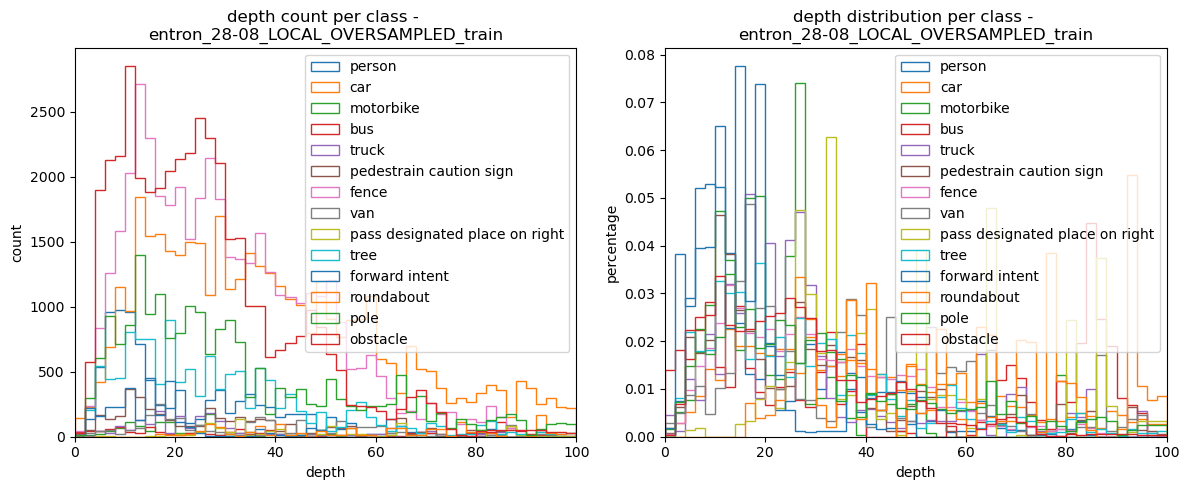

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PLOT COUNT
axes[0].set_title(f'depth count per class - \n{(ds_name)}')
axes[0].set_xlabel("depth")
axes[0].set_ylabel("count")
axes[0].set_xlim((0,100))
for category, category_df in ann_df.groupby("category_id"):
    if category_df.shape[0] > instance_threshold:
        axes[0].hist(category_df['depth'],
                 label=class_mapping[category], bins=50, range=[0,100], histtype='step')
axes[0].legend()

# PLOT DENSITY - TODO: too crowded
axes[1].set_title(f"depth distribution per class - \n{ds_name}")
axes[1].set_xlabel("depth")
axes[1].set_ylabel("percentage")
axes[1].set_xlim((0,100))
for category, category_df in ann_df.groupby("category_id"):
    if category_df.shape[0] > instance_threshold:
        axes[1].hist(category_df['depth'],
                 label=class_mapping[category], bins=50, range=[0,100], histtype='step', density=True)
axes[1].legend()

plt.tight_layout()
plt.show()

## azimuth

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: 'azimuth_3d_deg'

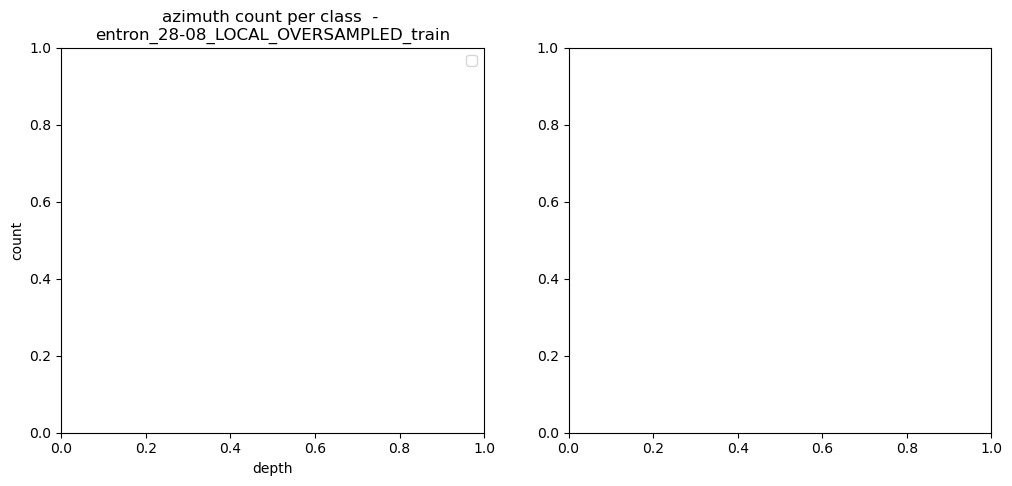

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PLOT COUNT
axes[0].set_title(f"azimuth count per class  - \n{ds_name}")
axes[0].set_xlabel("depth")
axes[0].set_ylabel("count")
axes[0].legend()
for category, category_df in ann_df.groupby("category_id"):
    if category_df.shape[0] > instance_threshold:
        axes[0].hist(category_df['azimuth_3d_deg'],# alpha=0.3, 
                 label=class_mapping[category], bins=25,
                 histtype='step') # , color=colormap[category])

# PLOT DENSITY - TODO: too crowded
axes[1].set_title(f"azimuth distribution per class - \n{ds_name}")
axes[1].set_xlabel("depth")
axes[1].set_ylabel("count")
for category, category_df in ann_df.groupby("category_id"):
    if category_df.shape[0] > instance_threshold:
        axes[1].hist(category_df['azimuth_3d_deg'],
                 label=class_mapping[category], bins=25,
                 histtype='step', density=True)
axes[1].legend()


# plt.legend()
plt.show()

## locations

In [ ]:
# for category, category_df in ann_df.groupby("category_id"):
#     if len(category_df) < instance_threshold:
#         continue

#     # _heatmap = np.zeros(image_shape[:2])
    
#     xs = [x for x,y,z in category_df['location']]
#     zs = [z for x,y,z in category_df['location']]

#     plt.figure()
#     plt.title(f"{class_mapping[category]} locations histogram- \n{ds_name}")
#     plt.hist2d(xs, zs, bins=60, range=[[-75, 75], [0, 120]])
#     plt.show()
    

KeyError: 1

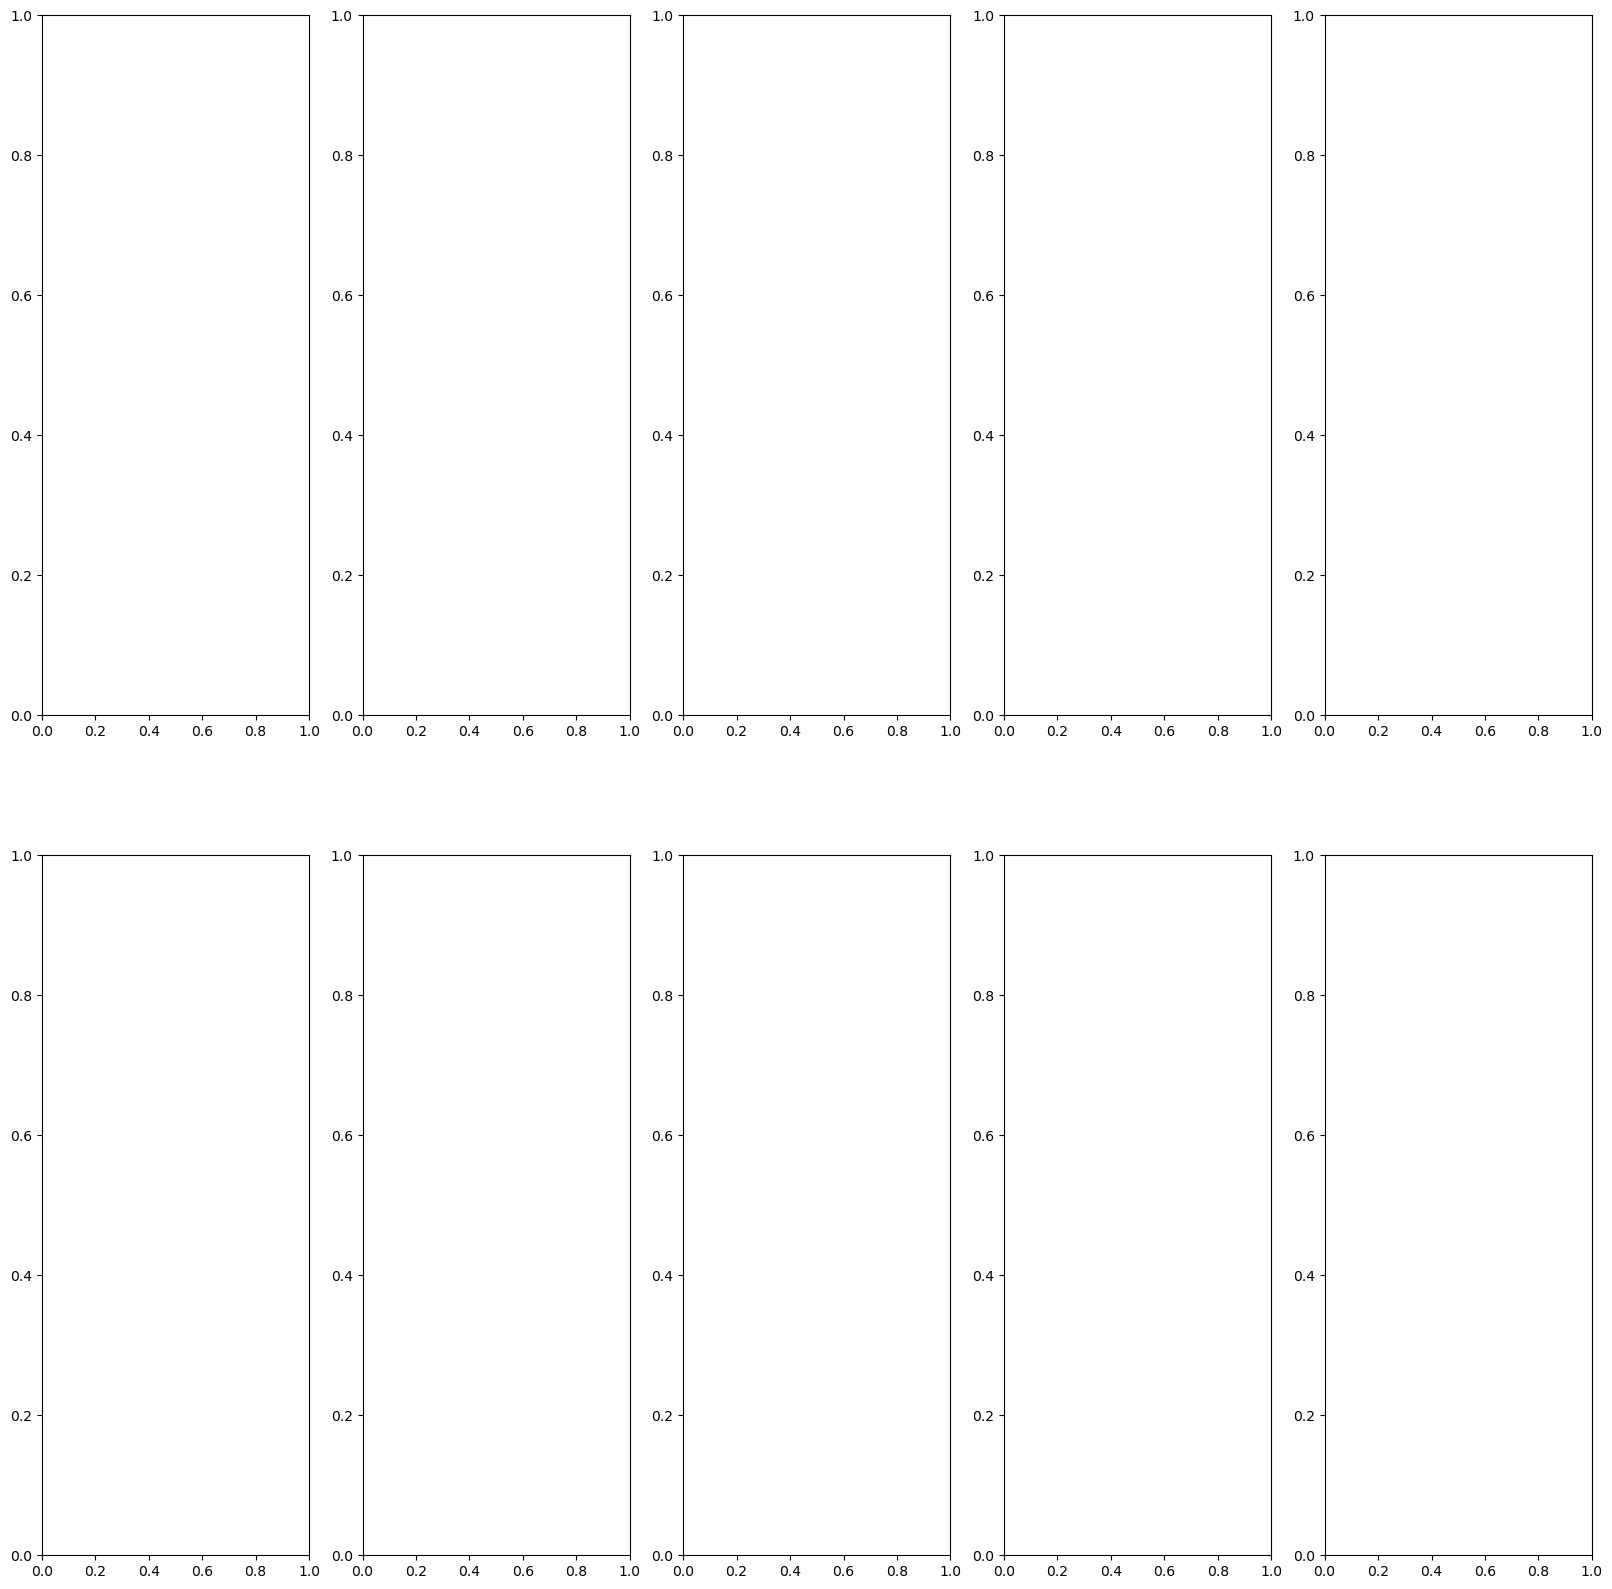

In [ ]:
n_cols = 5
n_rows = int(ann_df['category_id'].nunique() / n_cols)

f,axes= plt.subplots(n_rows,n_cols, figsize=(20,20))
axes = axes.flatten()
i=0
for category_index, (category, category_df) in enumerate(ann_df.groupby("category_id")):
    if len(category_df) < instance_threshold:
        continue
    
    # print('continued')
    xs = [x for x,y,z in category_df['location']]
    zs = [z for x,y,z in category_df['location']]

    axes[i].set_title(f"{class_mapping[category]} locations histogram - \n{ds_name}")
    axes[i].hist2d(xs, zs, bins=60, range=[[-75, 75], [0, 120]])
    i+=1

# clean unnecessary plots
for idx, ax in enumerate(axes.flatten()):
    if idx >= i:
        plt.delaxes(ax)
plt.tight_layout()
plt.show()
    

## bbox size histogram

In [ ]:
# # temp = ann_df.groupby("category_id")
# # print(temp.get_group(1))
# bbox_widths = {}
# bbox_heights = {}

# for category, category_df in (ann_df.groupby("category_id")):
#     bbox_widths[category] = [bbox[2] for bbox in category_df['bbox']]
#     bbox_heights[category] = [bbox[3] for bbox in category_df['bbox']]

# # print(bbox_widths)
# f,axes= plt.subplots(1,2, figsize = (10,4))
# y,x,_ = axes[0].hist(bbox_widths[i], bins=50)
# axes[0].set_title(f'bbox width - \n{ds_name}')
# axes[0].axvline(np.mean(bbox_widths[i]), color='k', linestyle='dashed', linewidth=1)
# axes[0].text(np.mean(bbox_widths[i])*1.1, y.max(), 
#                 'Mean: {:.2f}'.format(np.mean(bbox_widths[i])))
# axes[0].set_xlabel('bbox_widths [pixels]')
# axes[0].set_ylabel('count')



# y,x,_ = axes[1].hist(bbox_heights[i], bins=50)
# axes[1].set_title(f'bbox height- \n{ds_name}')
# axes[1].axvline(np.mean(bbox_heights[i]), color='k', linestyle='dashed', linewidth=1)
# axes[1].text(np.mean(bbox_heights[i])*1.1, y.max(), 
#                'Mean: {:.2f}'.format(np.mean(bbox_heights[i])))
# axes[1].set_xlabel('bbox_heights [pixels]')
# axes[1].set_ylabel('count')


# plt.tight_layout()


# # TODO - better to show as 2d hist? (next cell)

NameError: name 'bbox_heights' is not defined

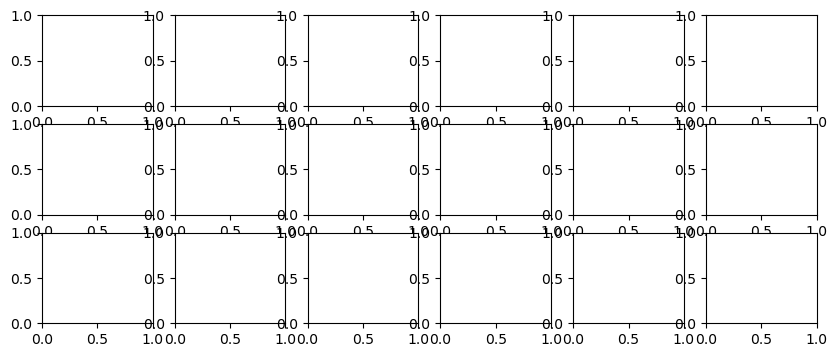

In [ ]:
# TODO - fix this

f,axes= plt.subplots(3,6, figsize = (10,4))
axes = axes.flatten()

# axes[0].hist2d(bbox_widths[category], bbox_heights[category], bins=60, range=[[0,1000], [0, 1000]])

for class_idx in range(1,len(axes)):
    _heatmap = np.zeros(image_shape[:2])
    axes[class_idx].hist2d(bbox_heights[class_idx],bbox_widths[class_idx], bins=60, range=[[0,1300], [0, 1300]])

    # for bbox_height,bbox_width in zip(bbox_heights[class_idx],bbox_widths[class_idx]):
    #     frame = np.zeros(image_shape[:2])
    #     cv2.rectangle(frame, (bbox_width,bbox_height),(bbox_width+1,bbox_height+1), color=(1,), thickness=-1)
    #     _heatmap += frame

    # axes[class_idx].imshow(_heatmap)
plt.tight_layout()

## bbox heatmaps

In [ ]:
# TODO !!! - optimize this, very inefficient for large datasets !!!


cat_bbox_heatmaps = {}

for category, category_df in tqdm(ann_df.groupby("category_id")):
    if len(category_df) < instance_threshold:
        continue

    _heatmap = np.zeros(image_shape[:2])
    for bbox in category_df['bbox']:
        x,y,dx,dy = bbox
        x1 = (x,y)
        x2 = (x+dx, y+dy)
        frame = np.zeros(image_shape[:2])
        cv2.rectangle(frame, x1, x2, color=(1,), thickness=-1)
        _heatmap += frame
    _heatmap /= len(category_df)
    cat_bbox_heatmaps[category] = _heatmap

100%|██████████| 42/42 [06:20<00:00,  9.06s/it]


In [ ]:
# PLOT ALL TOGETHER

number_of_heatmaps = len(cat_bbox_heatmaps.keys())
n_cols = 5
n_rows = int(number_of_heatmaps / n_cols)+1
f,axes= plt.subplots(n_rows,n_cols,figsize=(15, 8))
axes = axes.flatten()
for cat_index, (cat, hm) in enumerate(cat_bbox_heatmaps.items()):
    axes[cat_index].imshow(hm)
    axes[cat_index].set_title(f"{class_mapping[cat]} heatmap - \n{ds_name}")


# clean unnecessary plots
for idx, ax in enumerate(axes.flatten()):
    if idx > cat_index:
        plt.delaxes(ax)
plt.tight_layout()
plt.show()


NameError: name 'cat_bbox_heatmaps' is not defined

In [ ]:
# PLOT HEATMAPS SEPARATELY

# for cat, hm in cat_bbox_heatmaps.items():
#     # print(hm.min(), hm.max())
#     plt.figure()
#     plt.title(f"{class_mapping[cat]} heatmap - \n {ds_name}")
#     plt.imshow(hm)
#     plt.colorbar()
#     plt.show()

## Sheba Bus Stations

In [ ]:
import json
from collections import defaultdict
import tqdm
import pandas as pd
from collections import OrderedDict
import os
import pandas as pd


ds = coco_path

with open(ds,"r") as data_file:
    data=json.load(data_file)

ds_name = os.path.basename(ds).split('.')[0]

In [ ]:
category_counter = defaultdict(int)
max_dist = 0
station_annotations = []
# count the existing categories
for ann_data in data['annotations']:
    if 174<= ann_data['category_id'] <=191:
        # count per category
        category_counter[ann_data['category_id']] += 1
        
        # save bus annotations
        station_annotations.append(ann_data)
        
        # find max distance station
        if ann_data['location'][2] > max_dist:
            max_dist = ann_data['location'][2]
            image_id = ann_data['image_id']
            # print(f'{ann_data["category_id"] = }')
            # print(f'{data["images"][image_id]["file_name"]}')
            # print(f'{max_dist = }')

# bus categories that weren't found - mark as 0 for the figure
for i in range(174,192):
    if i not in category_counter.keys():
        category_counter[i] = 0

# max_dist, image_id, data['images'][image_id]['file_name']

In [ ]:
category_counter = (category_counter)
category_counter = OrderedDict(sorted(category_counter.items()))

class_mapping = {x['id']:x['name'] for x in data['categories']}
class_names = [class_mapping.get(index) for index in category_counter.keys()]
class_names = [item.replace(' ', '\n') for item in class_names]

AttributeError: 'NoneType' object has no attribute 'replace'

In [ ]:
# replace cat id with cat name
new_category_counter = {new_key: category_counter[old_key] for new_key, old_key in zip(class_names, category_counter.keys())}

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using Seaborn
sns.barplot(x=list(new_category_counter.keys()), y=list(new_category_counter.values()))

# Add labels to the bars
for i, count in enumerate(category_counter.values()):
    plt.text(i, count + 1, f'{count}', ha='center')

# Adjust the rotation of x-axis labels
plt.xticks(rotation='90')

# Set the title
plt.title(f"# appearances of stations - {ds_name}")

# Display the plot
plt.tight_layout()
plt.show()


TypeError: 'NoneType' object is not callable

In [ ]:
station_annotations_df = pd.DataFrame(station_annotations)
# station_annotations_df

In [ ]:
# list images showing stations
images_with_stations = list(station_annotations_df['image_id'].unique())
images_with_stations

In [ ]:
# create station2image dictionary
station_df = station_annotations_df.groupby('category_id')
station_to_images = {}
for cat_id in station_df.groups.keys():
    station_to_images.update({
        cat_id : list(station_df.get_group(cat_id)['image_id'].unique())
    })
station_to_images

NameError: name 'station_annotations_df' is not defined